Below is code that shows a basic implementation of a variational autoencoder. Models are built using keras' functional API as it makes it significantly easier to code more complicated loss functions like VAEs have.

The code constructs and trains both a standard autoencoder as well as a variational autoencoder using an intermediate dimension of 60 and a latent dimension of 2 using densely connected layers on the mnist fashion dataset. The small size of the latent dimension results in relatively imprecise reconstructions on such high dimensional input data but allows us to get a good image of what is happening in the latent space of a standard autoencoder vs a VAE

This demo is heavily based on the tutorial provided at https://blog.keras.io/building-autoencoders-in-keras.html

In [153]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt

#Batch size for model training purposes. You can adjust this to speed up training if you have the vram to handle it
batch = 100

Standard importing and reshaping of the mnist fashion data set. All pixel values are normalized to \[0,1]

In [154]:
(xTrain,yTrain),(xTest,yTest) = K.datasets.fashion_mnist.load_data()

xTrain = xTrain.astype('float32')/255
xTest = xTest.astype('float32')/255

xTrain = xTrain.reshape(60000,28*28)
xTest = xTest.reshape(10000,28*28)

This function defines how the sampling operation of the VAE is done. This is the part of the model that implements the "Reparameterization trick". We will pass this function as the input to a Keras Lambda layer in our VAE model

In [155]:
def sample(args):
    '''
    This function takes in a mean and standard deviation vector and returns an output sampled from a normal distribution using
    those vectors as the mean and standard deviation
    '''
    mean,std = args
    eps = K.backend.random_normal((batch,2))
    z = mean + std*eps
    return z


Very rudimentary implementation of an autoencoder. This block of code instantiates the overall autoencoder model which is trained and an encoder and decoder model that use the trained layers of the autoencoder model. An Adam optimizer is used with learning rate of .0001 and binary cross entropy is used for the reconstruction loss

In [156]:
aex = K.layers.Input((28*28))
aed1 = K.layers.Dense(60, activation='relu')(aex)
aez = K.layers.Dense(2)(aed1)

aed2 = K.layers.Dense(60,activation='relu')
aeout = K.layers.Dense(28*28,activation='sigmoid')

AEd2 = aed2(aez)
AEout = aeout(AEd2)

DECinput = K.layers.Input(2)
DECd2 = aed2(DECinput)
DECout = aeout(DECd2)

Autoencoder = K.Model(aex,AEout,name = "Autoencoder")
Autoencoder.compile(optimizer=K.optimizers.Adam(learning_rate=.0001),loss = K.losses.binary_crossentropy)
Encoder = K.Model(aex,aez,name = "Encoder")
Decoder = K.Model(DECinput,DECout,name = "Decoder")
Autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_76 (Dense)             (None, 60)                47100     
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 122       
_________________________________________________________________
dense_78 (Dense)             (None, 60)                180       
_________________________________________________________________
dense_79 (Dense)             (None, 784)               47824     
Total params: 95,226
Trainable params: 95,226
Non-trainable params: 0
_________________________________________________________________


This block of code instantiates the VAE as well as the recognition and generator models. As with the autoencoder, the VAE uses an Adam optimizer w/ learning rate of .0001 and binary as the reconstruction error term. The VAE has to define a custom loss which adds the reconstruction error to the KL Divergence loss term.

Something that I have come to find in the writing of this demo is that the relative weighting of the reconstruction and KL loss terms can be very finnicky. If left as how they are defined in most papers on the subject the KL loss term tends to dominate the reconstruction loss and the latent dimmension encoding essentially maps everything to zero with outputs of the generator model that don't look like anything. A general rule of thumb that I found in searching this issue is to multiply the reconstruction loss by the input dimension which works relatively well in this case. The weighting of the two loss terms is definately something to keep in mind when designing a VAE as I haven't seen this issue discussed too much in the reseach I did for this lesson and the exmaples I've seen treat the weighting of the terms as essentially another hyper parameter to tune for your specific model.

In [157]:
x = K.layers.Input((28*28))
d1 = K.layers.Dense(60,activation='relu')(x)
zmean = K.layers.Dense(2)(d1)
zstd = K.layers.Dense(2)(d1)
z = K.layers.Lambda(sample)([zmean,zstd])

d2 = K.layers.Dense(60,activation='relu')
out= K.layers.Dense(28*28,activation='sigmoid')

VAEd2 = d2(z)
VAEout = out(VAEd2)

GENinput = K.layers.Input(2)
GENd2 = d2(GENinput)
GENout = out(GENd2)

def vaeloss(input,output):
    reconstruction = K.losses.binary_crossentropy(input,output)*28*28
    KL_Loss = 0.5 * tf.reduce_sum(tf.square(zstd)+tf.square(zmean)-1-tf.log(tf.square(zstd)),axis=1)
    loss = reconstruction+KL_Loss
    return loss

vae = K.Model(x,VAEout,name = "VAE")
vae.compile(optimizer = K.optimizers.Adam(learning_rate=.0001), loss = vaeloss)
RecognitionModel = K.Model(x,zmean, name = "Recognition Model")
generator = K.Model(GENinput,GENout, name = "Generation Model")
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 60)           47100       input_37[0][0]                   
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 2)            122         dense_80[0][0]                   
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 2)            122         dense_80[0][0]                   
________________________________________________________________________________________________

Blocks to fit the models

In [158]:
AEhist = Autoencoder.fit(xTrain,xTrain, epochs = 50,validation_data=(xTest,xTest),batch_size=batch)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 40us/sample - loss: 0.5096 - val_loss: 0.4320
Epoch 2/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.4093 - val_loss: 0.3956
Epoch 3/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3879 - val_loss: 0.3835
Epoch 4/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3784 - val_loss: 0.3759
Epoch 5/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3716 - val_loss: 0.3702
Epoch 6/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3665 - val_loss: 0.3659
Epoch 7/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3622 - val_loss: 0.3617
Epoch 8/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3586 - val_loss: 0.3585
Epoch 9/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3557 - val_

In [159]:
VAEhist = vae.fit(xTrain,xTrain, epochs = 50,validation_data=(xTest,xTest),batch_size=batch)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 39us/sample - loss: 452.4931 - val_loss: 392.7791
Epoch 2/50
60000/60000 [==============================] - 2s 25us/sample - loss: 371.6052 - val_loss: 354.5624
Epoch 3/50
60000/60000 [==============================] - 2s 26us/sample - loss: 340.5778 - val_loss: 328.0236
Epoch 4/50
60000/60000 [==============================] - 2s 25us/sample - loss: 322.4222 - val_loss: 320.6361
Epoch 5/50
60000/60000 [==============================] - 2s 25us/sample - loss: 316.1041 - val_loss: 310.7783
Epoch 6/50
60000/60000 [==============================] - 2s 26us/sample - loss: 308.0894 - val_loss: 309.1787
Epoch 7/50
60000/60000 [==============================] - 2s 26us/sample - loss: 303.2154 - val_loss: 301.7126
Epoch 8/50
60000/60000 [==============================] - 2s 26us/sample - loss: 300.9984 - val_loss: 300.6948
Epoch 9/50
60000/60000 [==============================] - 2s 2

These two blocks show how well the two different models do at reconstructing the inputs they are given. Generally the standard autoencoder will perform better for this task becuase there is an inherent tradeoff when trying to force the latent dimmension to resemble a gaussian distribution particularly in a low capacity model such as this one.

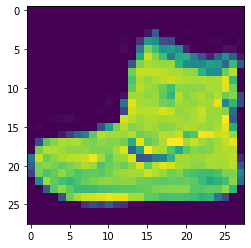

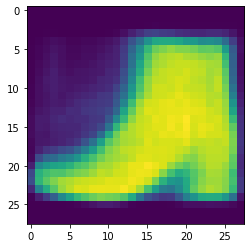

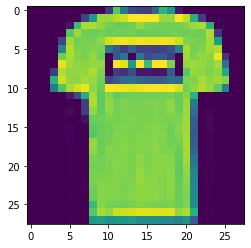

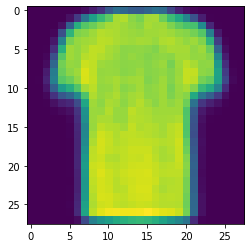

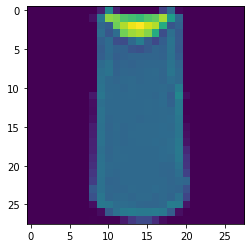

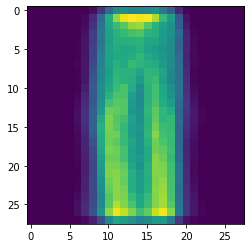

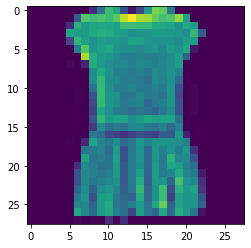

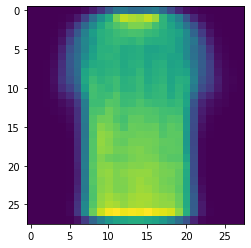

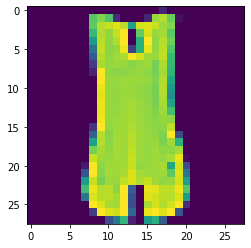

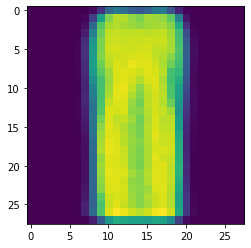

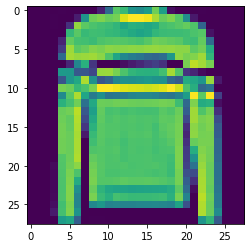

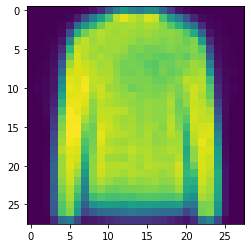

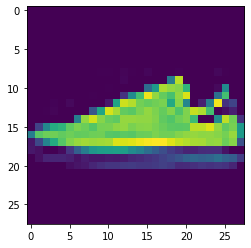

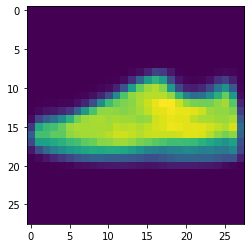

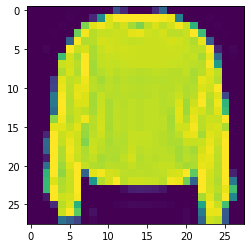

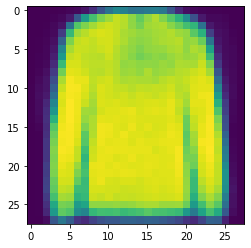

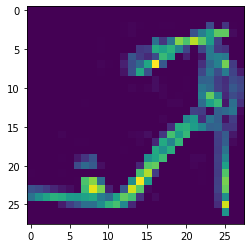

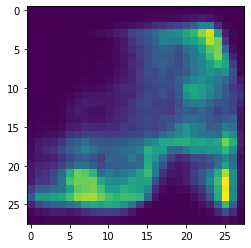

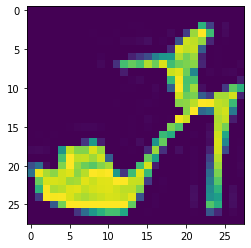

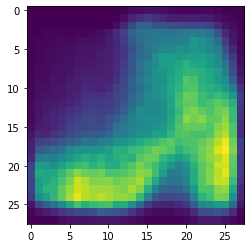

In [160]:
AEoutput = Autoencoder.predict(xTrain[:10])
for i in range(10):
    plt.figure()
    plt.imshow(xTrain[i,:].reshape(28,28))
    plt.figure()
    plt.imshow(AEoutput[i,:].reshape(28,28))

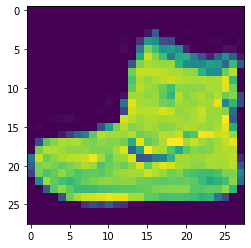

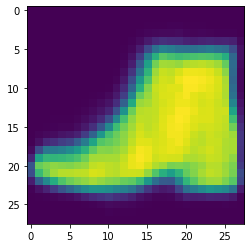

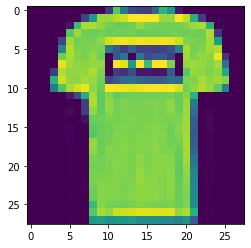

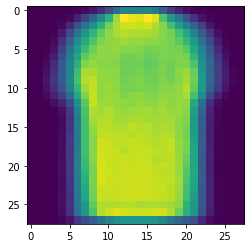

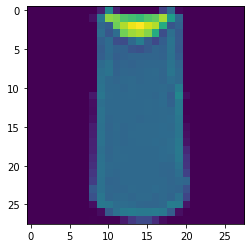

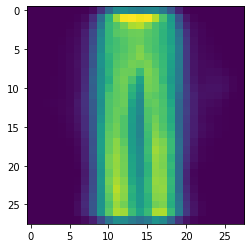

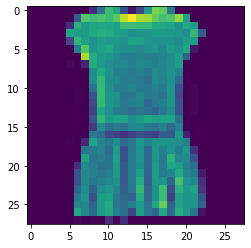

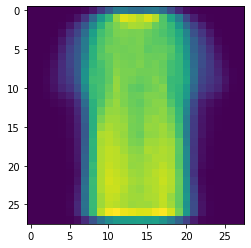

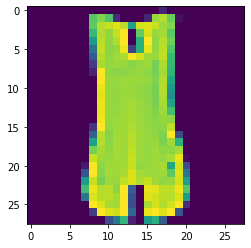

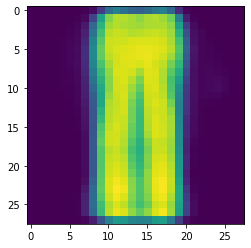

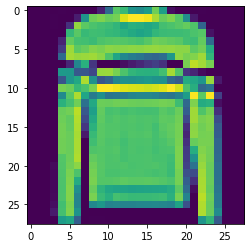

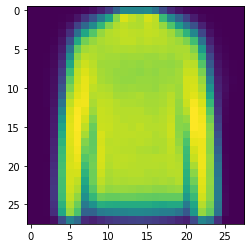

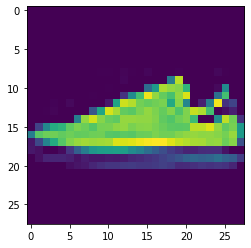

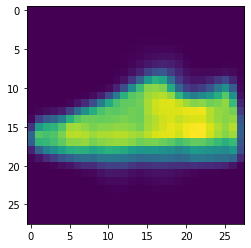

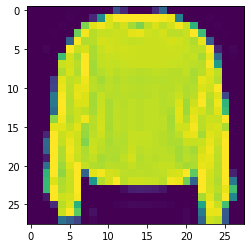

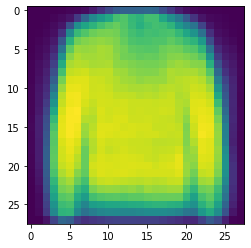

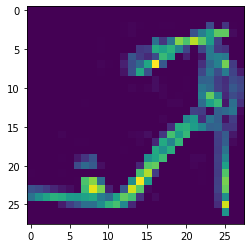

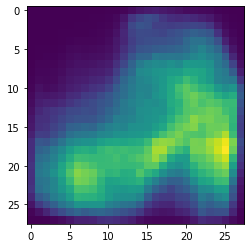

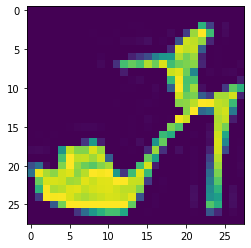

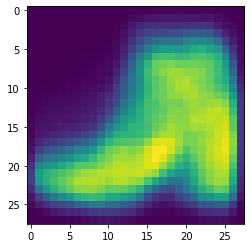

In [161]:
VAEoutput = vae.predict(xTrain[:100],batch_size=batch)
for i in range(10):
    plt.figure()
    plt.imshow(xTrain[i,:].reshape(28,28))
    plt.figure()
    plt.imshow(VAEoutput[i,:].reshape(28,28))

These two blocks show the difference in the latent space for the two models. Ideally you should see a scatter plot for the Autoencoder that shows that different classes are well grouped together in the latent space but the distribution of z values does not conform to the desired normal distribution of mean zero and standard deviation of one. The VAE should show a latent space that looks roughly like a two dimensional normal distribution

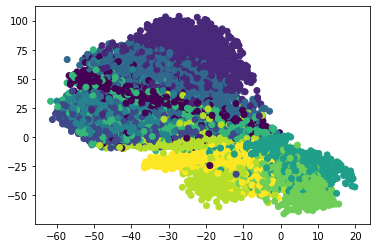

In [162]:
encoded = Encoder.predict(xTest)
plt.scatter(encoded[:,0],encoded[:,1],c = yTest)

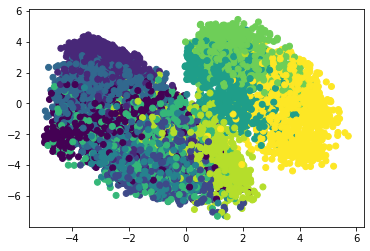

In [163]:
encoded = RecognitionModel.predict(xTest,batch_size=100)
plt.scatter(encoded[:,0],encoded[:,1],c = yTest)

These two blocks show how the two different models perform as generative models. You should see that the standard autoencoder output for the most part does not look like the training data. The VAE output should on the other hand have smooth transitions between different articles of clothing showing that no matter what value you sample from a normal distribution you should get something that looks like some piece of clothing. 

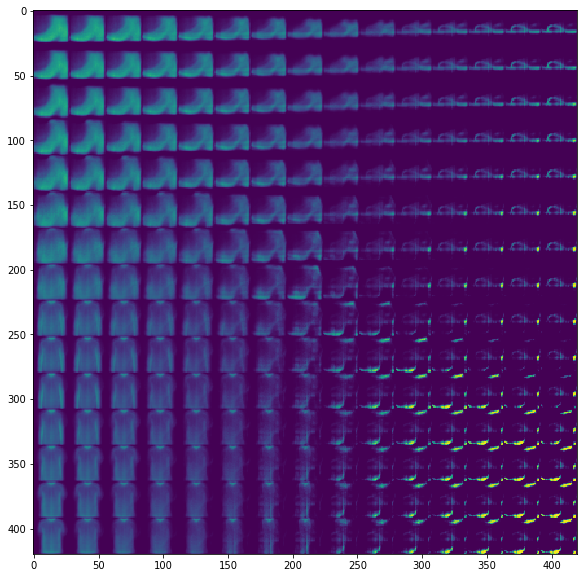

In [164]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

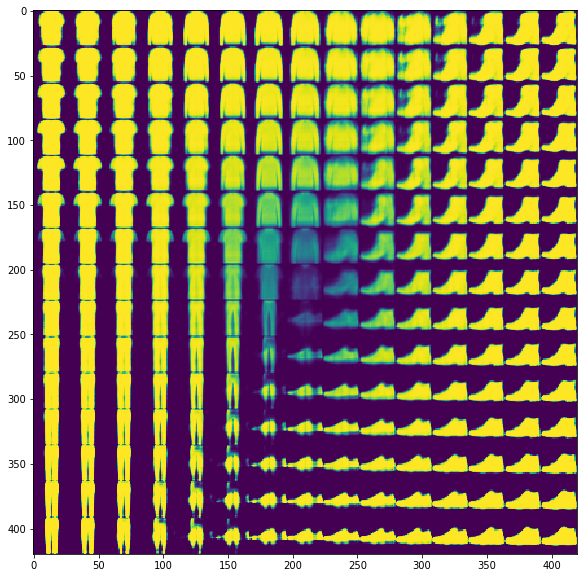

In [165]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

This block of code generates a random z value from a normal distribution and displays the output 

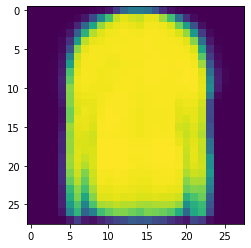

In [171]:
generated_img = generator.predict(tf.random_normal((1,2),stddev = 6),steps = 1)
plt.imshow(generated_img.reshape(28,28))